## Các thư viện cần thiết

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [32]:
df = pd.read_csv("du_lieu_da_xu_ly.csv",encoding='utf-8')

In [33]:
df.head()

,title,price,ratings,num_rates,screen_size,refresh_rate,chipset,GPU,sim_slot,internal_storage,battery,operating_system,RAM_in_GB
0,ASUS ROG Phone 6 12GB 256GB,14490000.0,5.0,20.0,6.78,120.0,Qualcomm ® Snapdragon ® 8+ thế hệ 1,Adreno ™ 730,2 SIM (Nano-SIM),256.0,6000.0,Android,12.0
1,BENCO V91 4GB 128GB,2690000.0,5.0,1.0,6.56,90.0,Unisoc T606,Adreno 610,2 SIM (Nano-SIM),128.0,5000.0,Android,8.0
2,Benco S1 Pro 8GB 256GB,4290000.0,5.0,10.0,6.80,120.0,Unisoc T616,Mali-G57,2 SIM (Nano-SIM),256.0,5000.0,Android,16.0
3,INOI 288S 4G,1000000.0,5.0,1.0,2.00,120.0,Apple A18 Pro,Adreno 610,2 SIM (Nano-SIM),128.0,1000.0,Android,8.0
4,INOI Note 13s 8GB 256GB,2790000.0,5.0,2.0,6.95,120.0,Unisoc T606,Adreno 610,2 SIM (Nano-SIM),256.0,5000.0,Android,8.0


In [34]:
# Thêm cột brand bằng cách tách tên hãng từ title
df['brand'] = df['title'].apply(lambda x: x.split()[0])

## Thống kê mô tả về giá.

c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


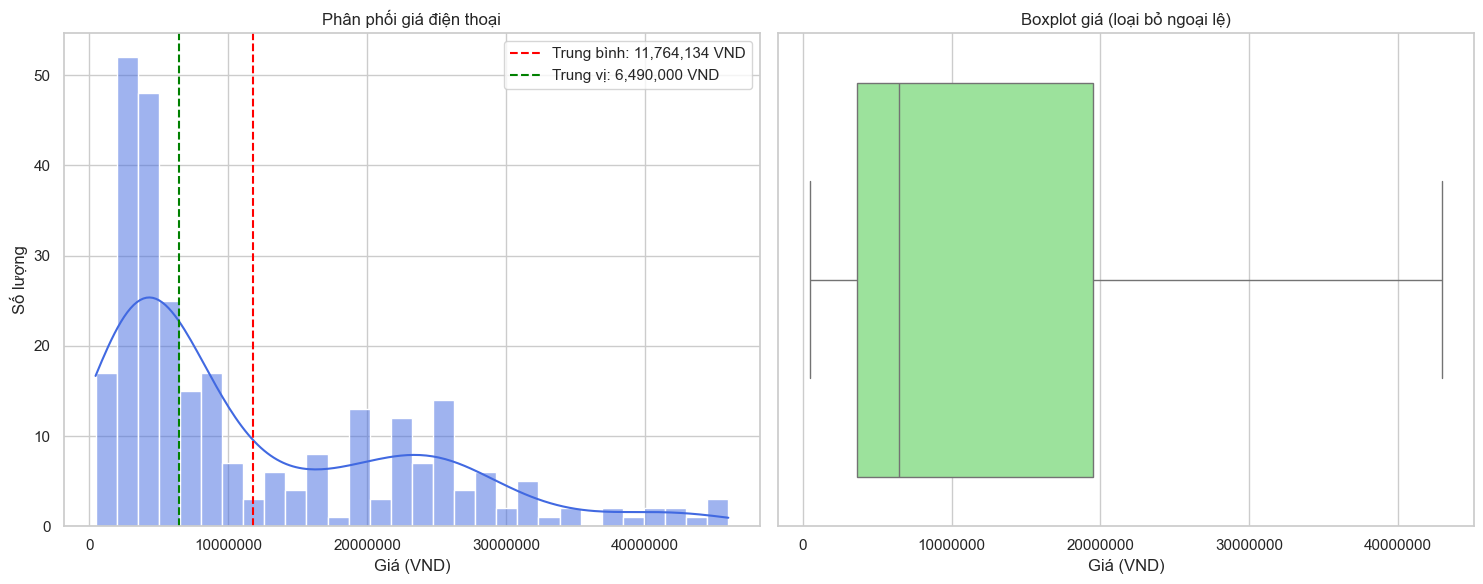


PHÂN VỊ GIÁ ĐIỆN THOẠI
0.25     3,625,000 VND
0.50     6,490,000 VND
0.75    19,490,000 VND
0.90    27,390,000 VND
0.95    31,990,000 VND
Name: price, dtype: object


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))

# 1. Biểu đồ phân phối giá
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, kde=True, color='royalblue')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Trung bình: {df["price"].mean():,.0f} VND')
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f'Trung vị: {df["price"].median():,.0f} VND')
plt.title('Phân phối giá điện thoại')
plt.xlabel('Giá (VND)')
plt.ylabel('Số lượng')
plt.legend()
plt.ticklabel_format(style='plain', axis='x')

# 2. Boxplot phân khúc giá
plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'], showfliers=False, color='lightgreen')
plt.title('Boxplot giá (loại bỏ ngoại lệ)')
plt.xlabel('Giá (VND)')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

# 3. Phân tích giá theo phân vị
percentiles = df['price'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print("\nPHÂN VỊ GIÁ ĐIỆN THOẠI")
print(percentiles.apply(lambda x: f"{x:,.0f} VND"))


PHÂN BỐ THEO PHÂN KHÚC GIÁ
price_segment
Dưới 5tr     117
5-15tr        77
15-30tr       70
Trên 30tr     19
Name: count, dtype: int64


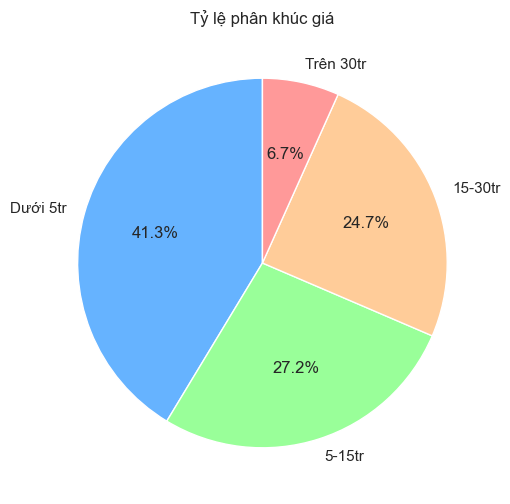

In [36]:
# Phân loại theo phân khúc giá
df['price_segment'] = pd.cut(df['price'], 
                            bins=[0, 5e6, 15e6, 30e6, float('inf')],
                            labels=['Dưới 5tr', '5-15tr', '15-30tr', 'Trên 30tr'])

# Thống kê số lượng theo phân khúc
segment_stats = df['price_segment'].value_counts().sort_index()
print("\nPHÂN BỐ THEO PHÂN KHÚC GIÁ")
print(segment_stats)

# Vẽ biểu đồ phân khúc
plt.figure(figsize=(8, 6))
segment_stats.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                  colors=['#66b3ff','#99ff99','#ffcc99','#ff9999'])
plt.title('Tỷ lệ phân khúc giá')
plt.ylabel('')
plt.show()

c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


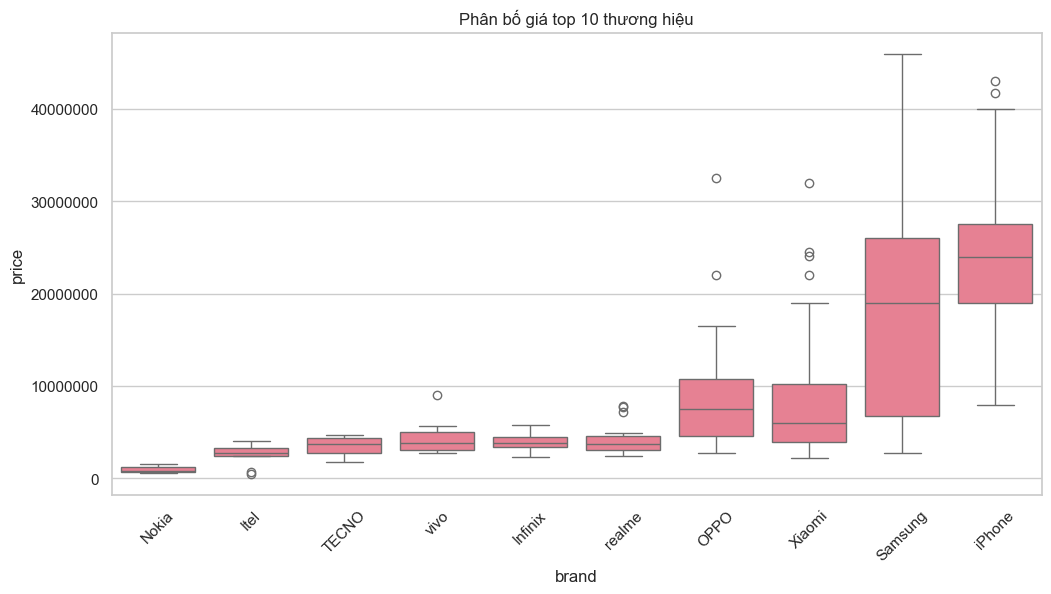

In [39]:
top_brands = df['brand'].value_counts().head(10).index
df_top = df[df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price', data=df_top)
plt.title('Phân bố giá top 10 thương hiệu')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Thống kê mô tả về RAM.

In [40]:
print(df['RAM_in_GB'].describe())

count    283.000000
mean       8.064212
std        3.367604
min        0.046875
25%        6.000000
50%        8.000000
75%        8.000000
max       28.000000
Name: RAM_in_GB, dtype: float64


c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


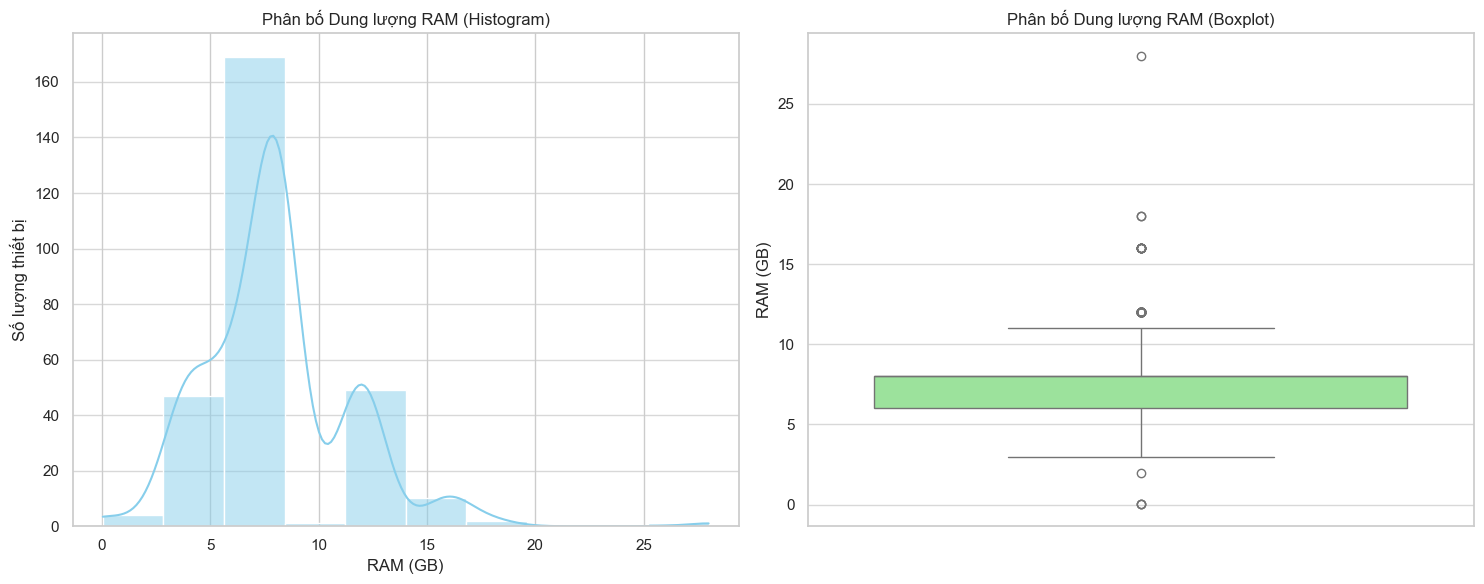

In [44]:
plt.figure(figsize=(15, 6))

# Biểu đồ tần suất (Histogram)
plt.subplot(1, 2, 1) # 1 hàng, 2 cột, biểu đồ thứ nhất
sns.histplot(df['RAM_in_GB'], bins=10, kde=True, color='skyblue')
plt.title('Phân bố Dung lượng RAM (Histogram)')
plt.xlabel('RAM (GB)')
plt.ylabel('Số lượng thiết bị')
plt.grid(axis='y', alpha=0.75)

# Biểu đồ hộp (Boxplot)
plt.subplot(1, 2, 2) # 1 hàng, 2 cột, biểu đồ thứ hai
sns.boxplot(y=df['RAM_in_GB'], color='lightgreen')
plt.title('Phân bố Dung lượng RAM (Boxplot)')
plt.ylabel('RAM (GB)')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ
plt.show()

In [46]:
# Đếm tần suất xuất hiện của từng giá trị RAM
ram_counts = df['RAM_in_GB'].value_counts().sort_index()
print("\nCác giá trị RAM và số lượng xuất hiện:")
print(ram_counts)

# In ra các giá trị RAM phổ biến nhất (top 5 chẳng hạn)
print("\nTop 5 giá trị RAM phổ biến nhất:")
print(df['RAM_in_GB'].value_counts().head(5))


Các giá trị RAM và số lượng xuất hiện:
RAM_in_GB
0.046875       1
0.062500       2
2.000000       1
3.000000       4
4.000000      42
5.000000       1
6.000000      40
8.000000     129
11.000000      1
12.000000     49
16.000000     10
18.000000      2
28.000000      1
Name: count, dtype: int64

Top 5 giá trị RAM phổ biến nhất:
RAM_in_GB
8.0     129
12.0     49
4.0      42
6.0      40
16.0     10
Name: count, dtype: int64


## Thống kê mô tả khác.

--- Thống kê mô tả cho các cột số ---
          ratings   num_rates  screen_size  refresh_rate  internal_storage  \
count  283.000000  283.000000   283.000000    283.000000        283.000000   
mean     4.905654   21.257951     6.387032    105.943463        202.600707   
std      0.142557   36.163545     1.040207     21.347438        124.157956   
min      4.000000    1.000000     1.770000     60.000000          1.000000   
25%      4.850000    5.000000     6.500000     90.000000        128.000000   
50%      5.000000   10.000000     6.670000    120.000000        128.000000   
75%      5.000000   21.000000     6.715000    120.000000        256.000000   
max      5.000000  287.000000     7.820000    144.000000        512.000000   

           battery  
count   283.000000  
mean   4120.621908  
std    1707.534829  
min       4.000000  
25%    4000.000000  
50%    5000.000000  
75%    5000.000000  
max    7000.000000  




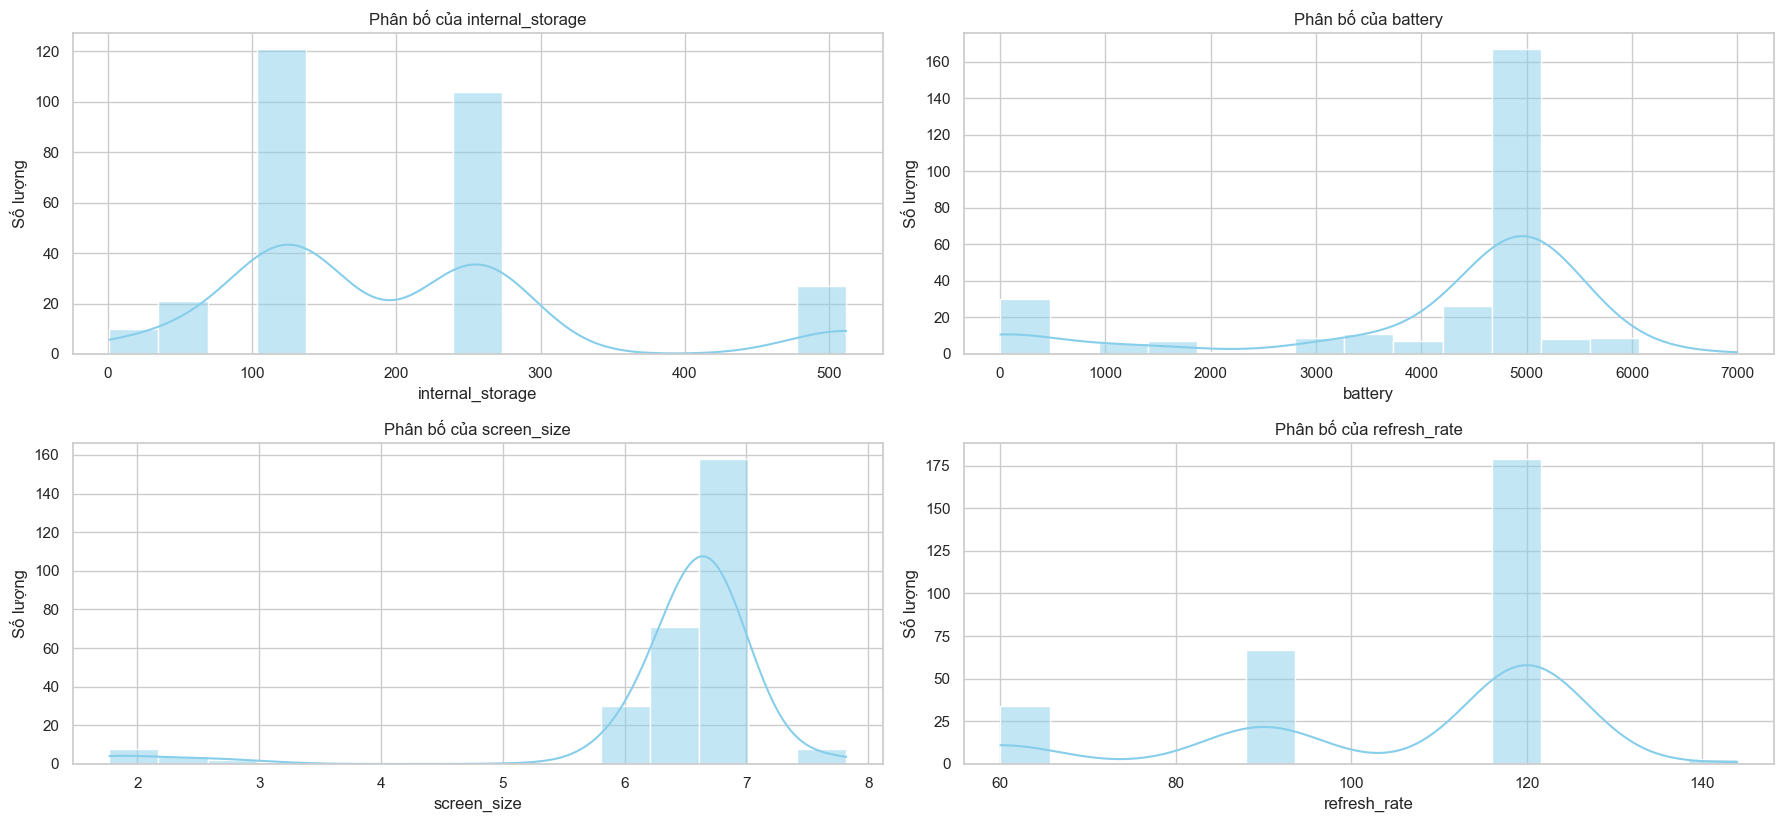

c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of p

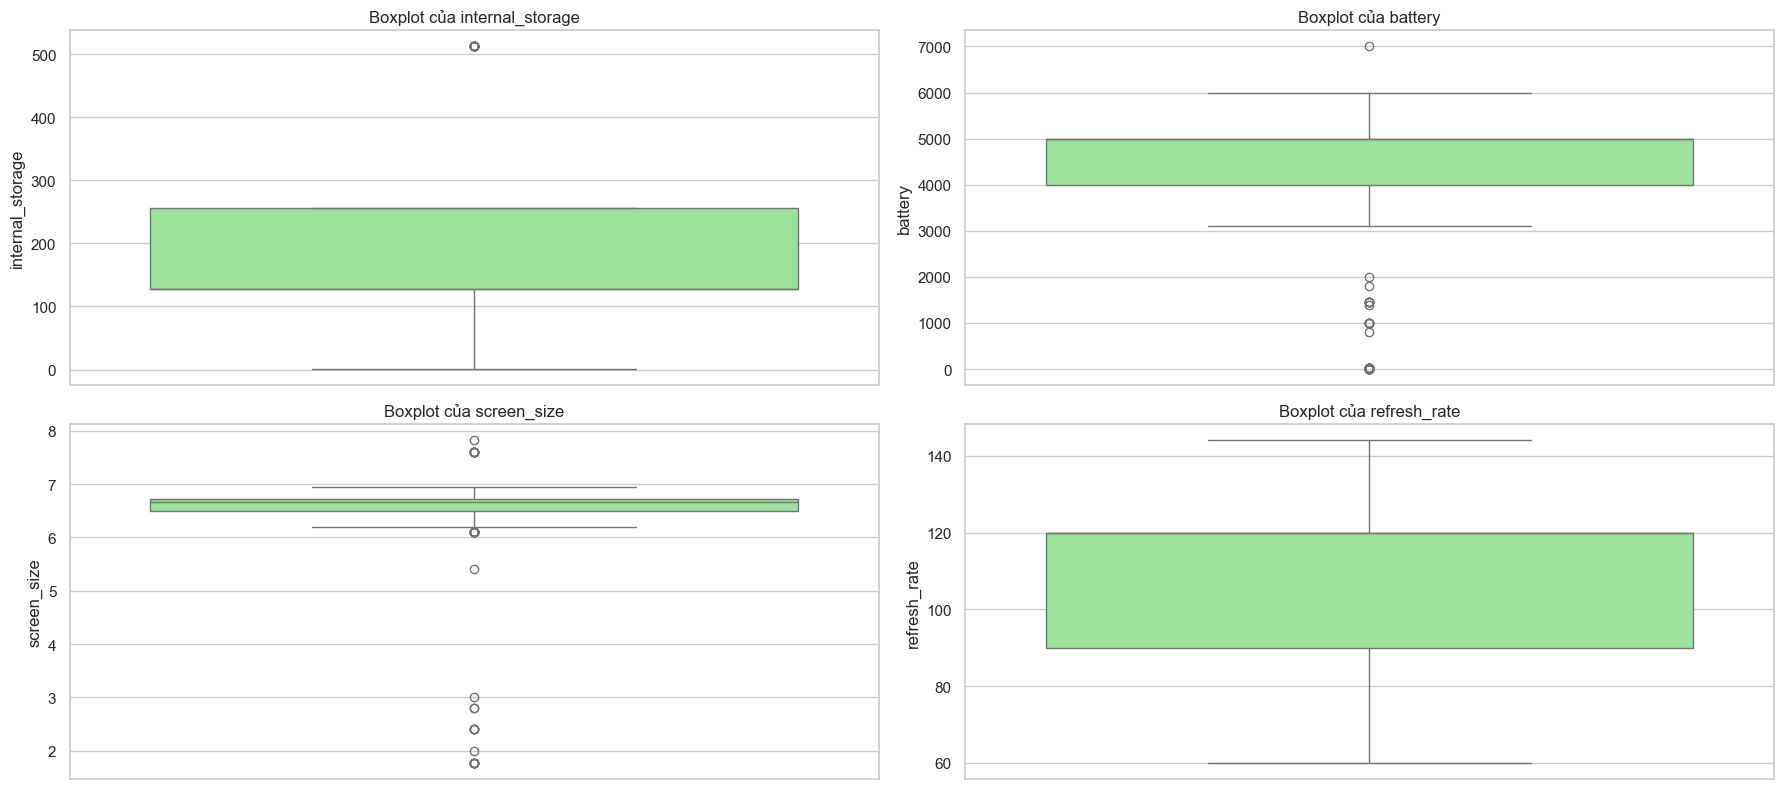

In [56]:
print("--- Thống kê mô tả cho các cột số ---")
print(df[['ratings', 'num_rates', 'screen_size', 'refresh_rate', 'internal_storage', 'battery']].describe())
print("\n")

# --- 3. Trực quan hóa Phân bố Dữ liệu Số ---
numeric_features = ['internal_storage', 'battery', 'screen_size', 'refresh_rate']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1) # 3 hàng, 2 cột
    sns.histplot(df[feature], bins=15, kde=True, color='skyblue')
    plt.title(f'Phân bố của {feature}')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(y=df[feature], color='lightgreen')
    plt.title(f'Boxplot của {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()



--- Phân tích tần suất cho các cột phân loại ---

--- Tần suất của chipset ---
chipset
Apple A18 Pro                               13
Snapdragon 8 Elite dành cho Galaxy (3nm)     7
Unisoc T606                                  7
MediaTek Helio G85 8 nhân                    7
Unisoc T107                                  6
                                            ..
Snapdragon 680 4G (6 nm)                     1
MediaTek Dimensity 7050 5G 8 nhân            1
Mediatek Dimensity 7050 (6 nm)               1
MediaTek Dimensity 7050                      1
MediaTek Helio G99-Ultra                     1
Name: count, Length: 151, dtype: int64


C:\Users\trinh\AppData\Local\Temp\ipykernel_20904\553184079.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_grou

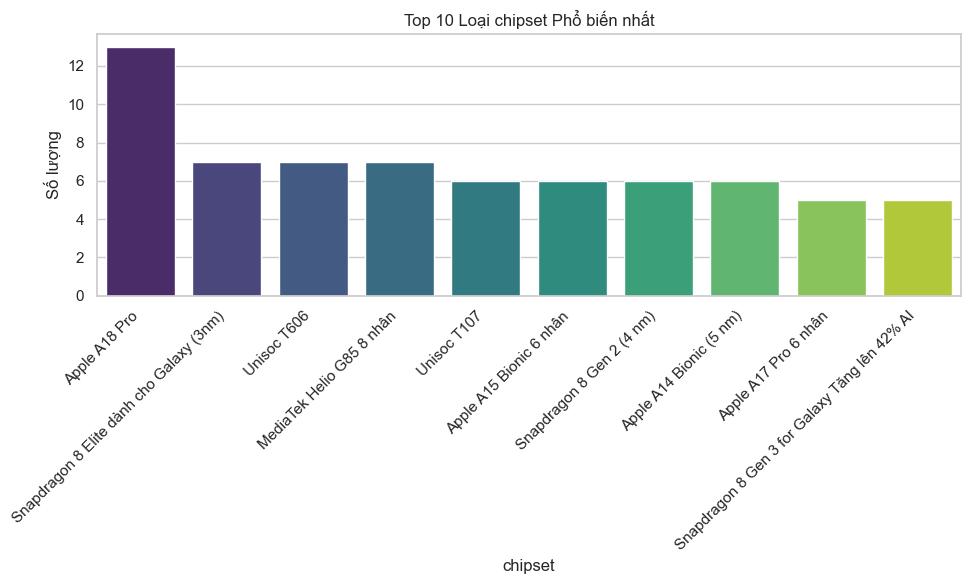


--- Tần suất của sim_slot ---
sim_slot
2 SIM (Nano-SIM)                                156
2 SIM (nano‑SIM và eSIM)                         43
2 Nano-SIM                                       23
Sim kép (nano-Sim và e-Sim) - Hỗ trợ 2 e-Sim     19
SIM 1 + SIM 2 / SIM 1 + eSIM / 2 eSIM            12
2 Nano SIM hoặc 1 Nano + 1 eSIM                   9
2 Nano-SIM + eSIM                                 8
Nano-SIM                                          3
Nano-SIM + eSIM                                   3
Micro-SIM + Nano SIM                              2
Dual nano-SIM hoặc 1 nano-SIM + 1 eSIM            2
1 Nano SIM + 1 eSIM hoặc 2 eSIM                   2
Micro-SIM                                         1
Name: count, dtype: int64


C:\Users\trinh\AppData\Local\Temp\ipykernel_20904\553184079.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_grou

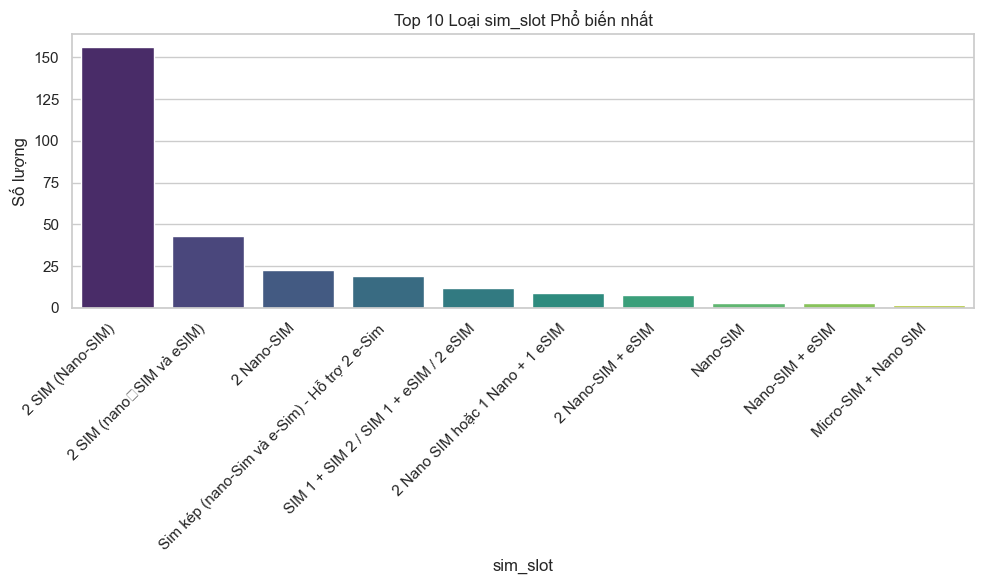


--- Tần suất của operating_system ---
operating_system
Android    225
iOS         49
Khác         6
S30+         3
Name: count, dtype: int64


C:\Users\trinh\AppData\Local\Temp\ipykernel_20904\553184079.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_grou

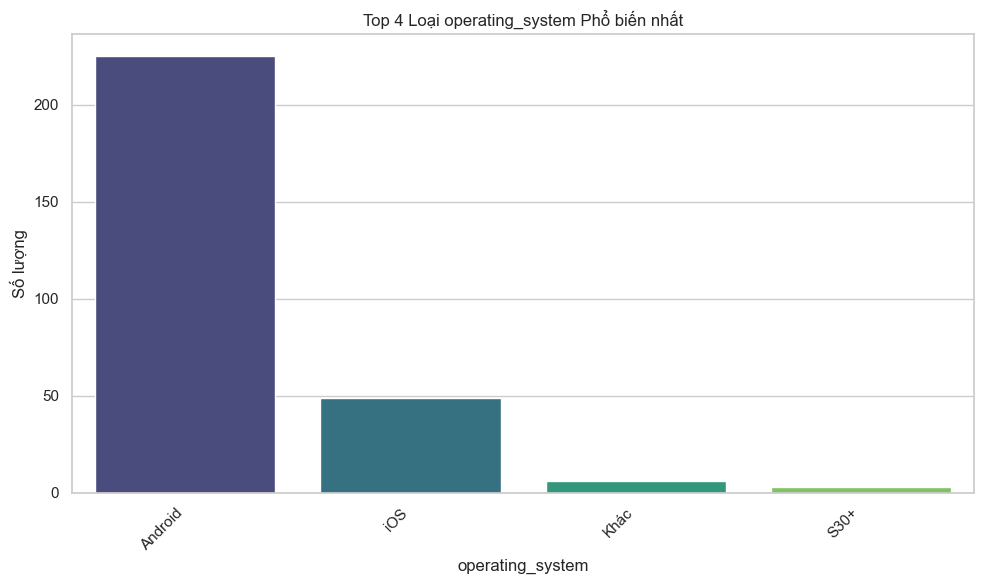


--- Phân tích mối quan hệ ---


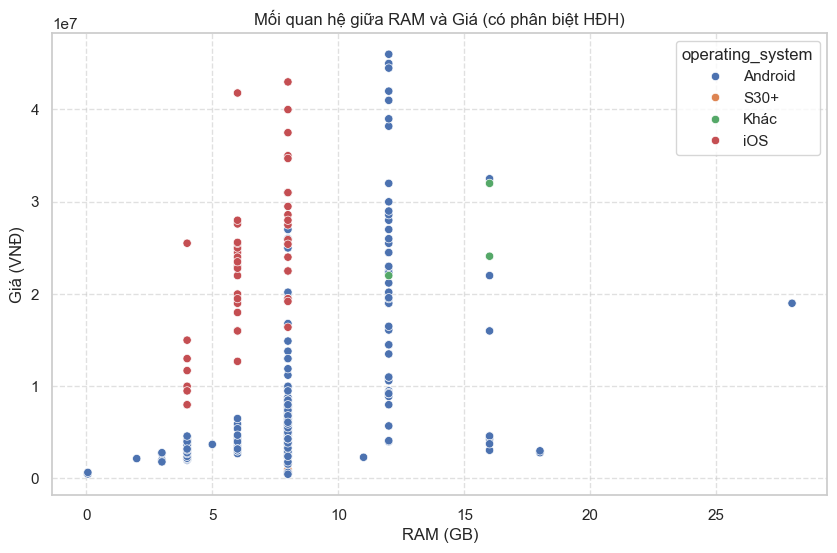

C:\Users\trinh\AppData\Local\Temp\ipykernel_20904\553184079.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_chipset.index, y=avg_price_by_chipset.values, palette='cividis')
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_d

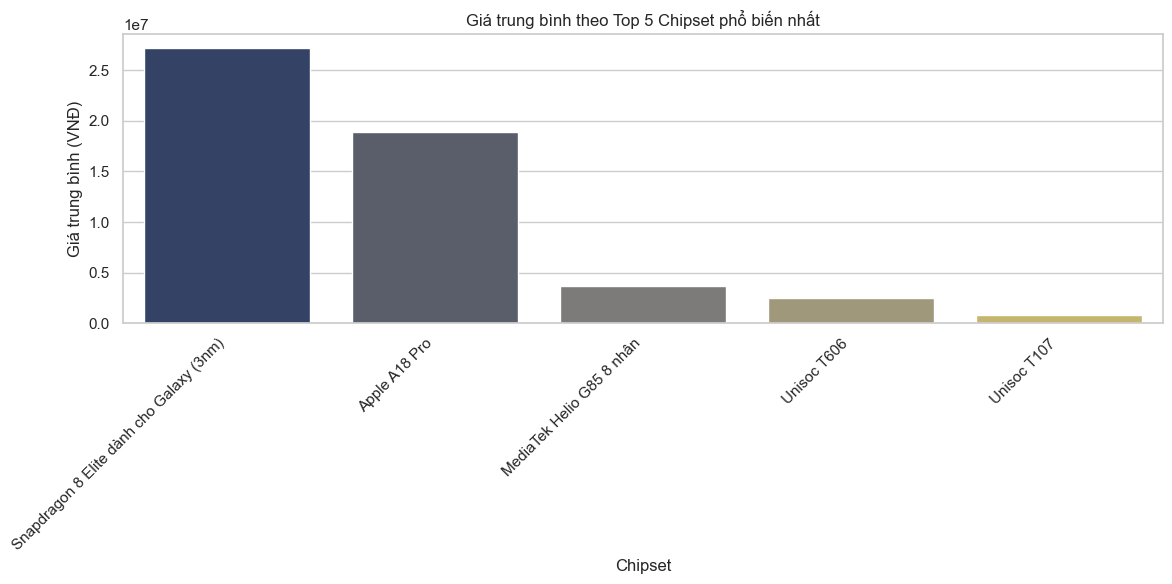

C:\Users\trinh\AppData\Local\Temp\ipykernel_20904\553184079.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ram_by_os.index, y=avg_ram_by_os.values, palette='plasma')
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

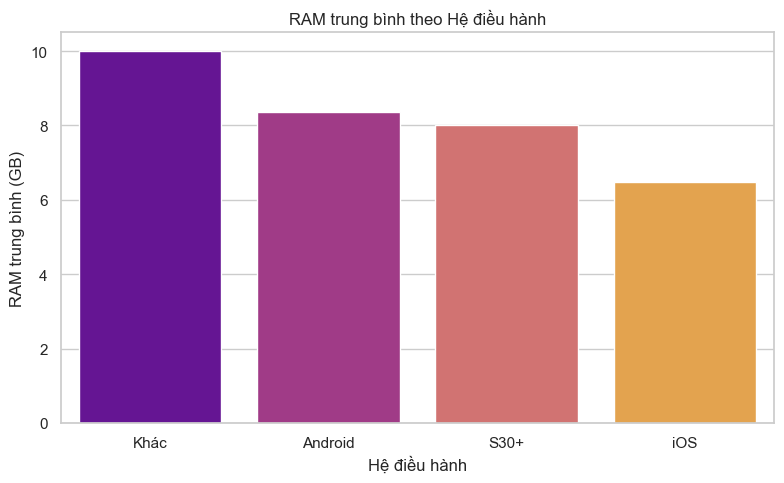

In [59]:
# --- 4. Phân tích Tần suất cho các Cột Phân loại ---
# Điều chỉnh tên cột GPU nếu cần, trong ảnh là một phần của chipset và sim_slot
# Trong dữ liệu mẫu của tôi, 'GPU' được tạo riêng, nếu của bạn nó là phần của cột khác thì bạn phải xử lý để tách nó ra
categorical_features = ['chipset', 'sim_slot', 'operating_system'] # Loại bỏ 'GPU' vì nó nằm trong 'chipset' hoặc 'sim_slot' trong hình ảnh

print("\n--- Phân tích tần suất cho các cột phân loại ---")
for feature in categorical_features:
    print(f"\n--- Tần suất của {feature} ---")
    print(df[feature].value_counts())
    
    # Trực quan hóa tần suất (Top 10 nếu có quá nhiều danh mục)
    plt.figure(figsize=(10, 6))
    top_categories = df[feature].value_counts().head(10)
    sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
    plt.title(f'Top {len(top_categories)} Loại {feature} Phổ biến nhất')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 5. Phân tích mối quan hệ đơn giản (một vài ví dụ) ---

print("\n--- Phân tích mối quan hệ ---")

# Mối quan hệ giữa RAM và Giá
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RAM_in_GB', y='price', data=df, hue='operating_system', palette='deep')
plt.title('Mối quan hệ giữa RAM và Giá (có phân biệt HĐH)')
plt.xlabel('RAM (GB)')
plt.ylabel('Giá (VNĐ)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# So sánh giá trung bình theo loại Chipset (Top 5 Chipset)
plt.figure(figsize=(12, 6))
# Lấy top 5 chipset phổ biến nhất trước khi tính trung bình để tránh quá nhiều danh mục
top_5_chipsets = df['chipset'].value_counts().head(5).index
df_filtered_chipset = df[df['chipset'].isin(top_5_chipsets)]
avg_price_by_chipset = df_filtered_chipset.groupby('chipset')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_chipset.index, y=avg_price_by_chipset.values, palette='cividis')
plt.title('Giá trung bình theo Top 5 Chipset phổ biến nhất')
plt.xlabel('Chipset')
plt.ylabel('Giá trung bình (VNĐ)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# So sánh RAM trung bình theo Hệ điều hành
plt.figure(figsize=(8, 5))
avg_ram_by_os = df.groupby('operating_system')['RAM_in_GB'].mean().sort_values(ascending=False)
sns.barplot(x=avg_ram_by_os.index, y=avg_ram_by_os.values, palette='plasma')
plt.title('RAM trung bình theo Hệ điều hành')
plt.xlabel('Hệ điều hành')
plt.ylabel('RAM trung bình (GB)')
plt.tight_layout()
plt.show()

## Huấn luyện và đánh giá mô hình

Kích thước tập huấn luyện X_train: (226, 10)
Kích thước tập kiểm tra X_test: (57, 10)


--- Bắt đầu huấn luyện mô hình Random Forest Regressor với dữ liệu chuẩn hóa ---
--- Huấn luyện mô hình hoàn tất! ---


--- Đánh giá hiệu suất mô hình với dữ liệu chuẩn hóa ---
Mean Absolute Error (MAE) (Standardized): 3,164,122.81
Mean Squared Error (MSE) (Standardized): 22,081,311,489,824.56
Root Mean Squared Error (RMSE) (Standardized): 4,699,075.60
R-squared (R2) (Standardized): 0.8320


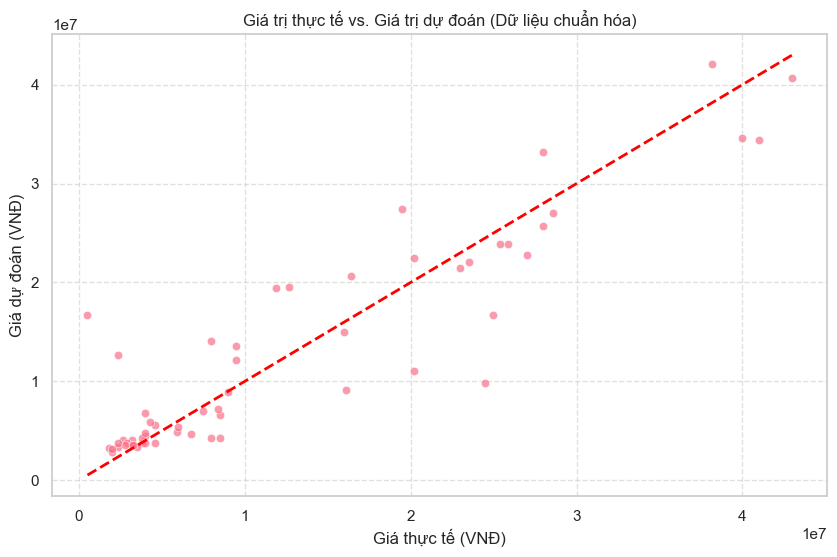


--- Độ quan trọng của các đặc trưng (Feature Importance) (Dữ liệu chuẩn hóa) ---
                                        Feature  Importance
142                   sim_slot_2 SIM (Nano-SIM)    0.410351
140                         sim_slot_2 Nano-SIM    0.193075
2                                   screen_size    0.104691
4                              internal_storage    0.085821
6                                     RAM_in_GB    0.036426
5                                       battery    0.020057
1                                     num_rates    0.019960
146                           sim_slot_Nano-SIM    0.014933
150                    operating_system_Android    0.011010
108  chipset_Snapdragon 8 Gen 3 Mobile Platform    0.010580


C:\Users\trinh\AppData\Local\Temp\ipykernel_20904\562278181.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_std.head(10), palette='magma')
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_da

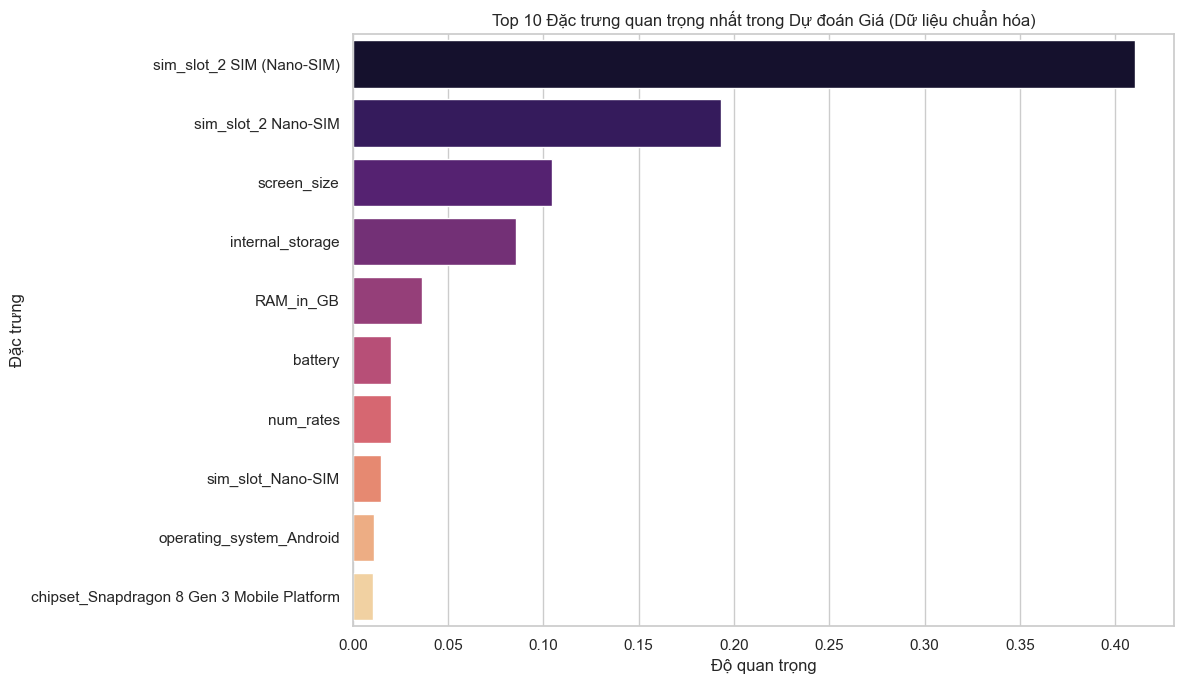

In [ ]:
# --- 2. Chọn Biến Độc lập (Features) và Biến Phụ thuộc (Target) ---
target = 'price'
numerical_features = ['ratings', 'num_rates', 'screen_size', 'refresh_rate', 'internal_storage', 'battery', 'RAM_in_GB']
categorical_features = ['chipset', 'sim_slot', 'operating_system']

X = df[numerical_features + categorical_features]
y = df[target]

# --- 3. Chia dữ liệu thành tập huấn luyện và tập kiểm tra ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện X_train: {X_train.shape}")
print(f"Kích thước tập kiểm tra X_test: {X_test.shape}")
print("\n")

# --- 4. Xây dựng Pipeline với Chuẩn hóa và Huấn luyện Mô hình ---
# Xác định các bước tiền xử lý
# 'num' cho StandardScaler, 'cat' cho OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Xây dựng Pipeline
model_standardized = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

print("--- Bắt đầu huấn luyện mô hình Random Forest Regressor với dữ liệu chuẩn hóa ---")
model_standardized.fit(X_train, y_train)
print("--- Huấn luyện mô hình hoàn tất! ---")
print("\n")

# --- 5. Đánh giá Hiệu suất Mô hình ---
print("--- Đánh giá hiệu suất mô hình với dữ liệu chuẩn hóa ---")
y_pred_standardized = model_standardized.predict(X_test)

mae_std = mean_absolute_error(y_test, y_pred_standardized)
mse_std = mean_squared_error(y_test, y_pred_standardized)
rmse_std = np.sqrt(mse_std)
r2_std = r2_score(y_test, y_pred_standardized)

print(f"Mean Absolute Error (MAE) (Standardized): {mae_std:,.2f}")
print(f"Mean Squared Error (MSE) (Standardized): {mse_std:,.2f}")
print(f"Root Mean Squared Error (RMSE) (Standardized): {rmse_std:,.2f}")
print(f"R-squared (R2) (Standardized): {r2_std:.4f}")

# Trực quan hóa kết quả dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_standardized, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Giá trị thực tế vs. Giá trị dự đoán (Dữ liệu chuẩn hóa)')
plt.xlabel('Giá thực tế (VNĐ)')
plt.ylabel('Giá dự đoán (VNĐ)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Phân tích độ quan trọng của các đặc trưng (Feature Importance)
feature_importances_std = model_standardized.named_steps['regressor'].feature_importances_

# Lấy tên cột sau khi tiền xử lý
# Numerical features vẫn giữ nguyên tên
# Categorical features sẽ có tên mới từ OneHotEncoder
numerical_feature_names = numerical_features # Tên của các cột số không thay đổi
onehot_feature_names = model_standardized.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names_std = list(numerical_feature_names) + list(onehot_feature_names)


importance_df_std = pd.DataFrame({'Feature': all_feature_names_std, 'Importance': feature_importances_std})
importance_df_std = importance_df_std.sort_values(by='Importance', ascending=False)

print("\n--- Độ quan trọng của các đặc trưng (Feature Importance) (Dữ liệu chuẩn hóa) ---")
print(importance_df_std.head(10))

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df_std.head(10), palette='magma')
plt.title('Top 10 Đặc trưng quan trọng nhất trong Dự đoán Giá (Dữ liệu chuẩn hóa)')
plt.xlabel('Độ quan trọng')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()

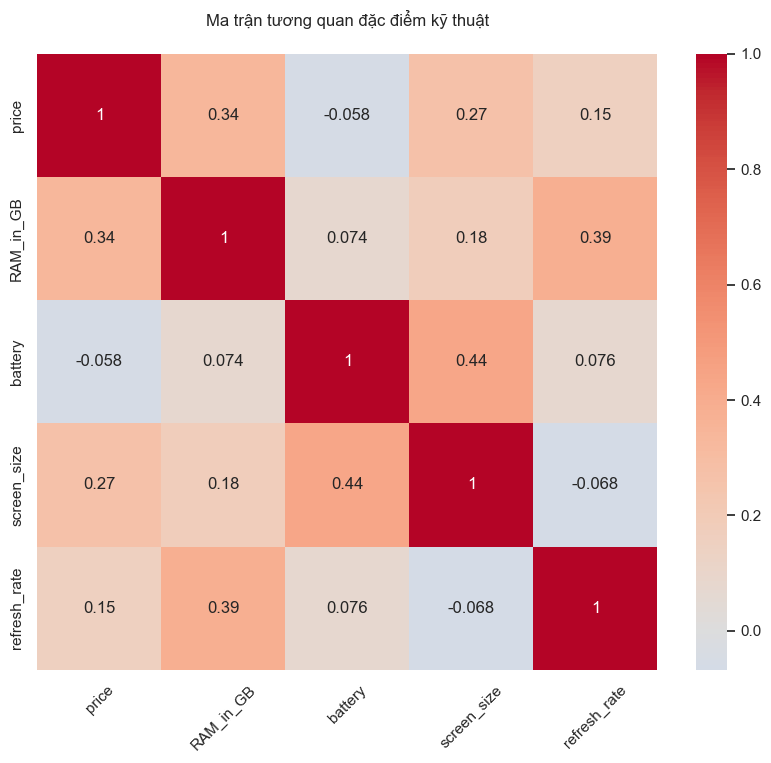

c:\Users\trinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


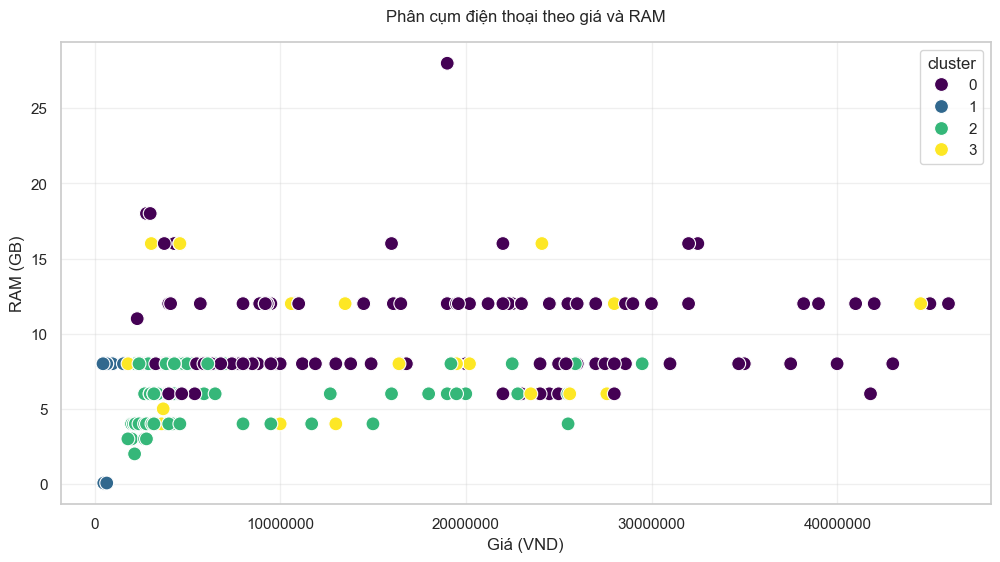

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Thiết lập giao diện đồ họa bằng seaborn
sns.set_theme(style="whitegrid", palette="husl")

# 1. Phân tích tương quan đa biến
numeric_cols = ['price', 'RAM_in_GB', 'battery', 'screen_size', 'refresh_rate']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Ma trận tương quan đặc điểm kỹ thuật', pad=20)
plt.xticks(rotation=45)
plt.show()

# 2. Phân cụm giá trị
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_cols])

# Phân cụm K-means
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize phân cụm
plt.figure(figsize=(12, 6))
sns.scatterplot(x='price', y='RAM_in_GB', hue='cluster', data=df, palette='viridis', s=100)
plt.title('Phân cụm điện thoại theo giá và RAM', pad=15)
plt.xlabel('Giá (VND)')
plt.ylabel('RAM (GB)')
plt.ticklabel_format(style='plain', axis='x')
plt.grid(True, alpha=0.3)
plt.show()
